In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(
    host="localhost",
    user="root",  # use 'user', not 'username'
    password="Nikita123",
    database="ecommerce"  # fixed typo here
)

cur = db.cursor()  # define cursor properly
print("Code executed successfully ✅")


Code executed successfully ✅


# List all unique cities where customers are located.

In [2]:
query = "SELECT DISTINCT customer_city FROM customers"
cur.execute(query)
data = cur.fetchall()
(data)


[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

In [3]:
cur.execute("SHOW TABLES;")
tables = cur.fetchall()
for table in tables:
    print(table)



('customers',)
('geolocation',)
('order_items',)
('orders',)
('payments',)
('products',)
('sellers',)


# Count the number of orders placed in 2017.

In [4]:
query = "SELECT COUNT(order_id) FROM orders WHERE order_purchase_timestamp LIKE '2017%'"
cur.execute(query)
data = cur.fetchall()
(data)


[(0,)]

In [5]:
query = "DESCRIBE orders;"
cur.execute(query)
data = cur.fetchall()
for row in data:
    print(row)



('order_id', 'text', 'YES', '', None, '')
('customer_id', 'text', 'YES', '', None, '')
('order_status', 'text', 'YES', '', None, '')
('order_purchase_timestamp', 'text', 'YES', '', None, '')
('order_approved_at', 'text', 'YES', '', None, '')
('order_delivered_carrier_date', 'text', 'YES', '', None, '')
('order_delivered_customer_date', 'text', 'YES', '', None, '')
('order_estimated_delivery_date', 'text', 'YES', '', None, '')


In [6]:
query = """
SELECT COUNT(order_id)
FROM orders
WHERE YEAR(STR_TO_DATE(order_purchase_timestamp, '%m/%d/%Y %H:%i')) = 2017;
"""
cur.execute(query)
data = cur.fetchall()
"Total order Placed in 2017 are", data [0][0]


('Total order Placed in 2017 are', 90202)

# Find the total sales per category.

In [8]:
cur.execute("SHOW COLUMNS FROM products")
for row in cur.fetchall():
    print(row)


('product_id', 'text', 'YES', '', None, '')
('product_category', 'text', 'YES', '', None, '')
('product_name_length', 'float', 'YES', '', None, '')
('product_description_length', 'float', 'YES', '', None, '')
('product_photos_qty', 'float', 'YES', '', None, '')
('product_weight_g', 'float', 'YES', '', None, '')
('product_length_cm', 'float', 'YES', '', None, '')
('product_height_cm', 'float', 'YES', '', None, '')
('product_width_cm', 'float', 'YES', '', None, '')


In [10]:
cur.execute("DESCRIBE payments")
for row in cur.fetchall():
    print(row)


('order_id', 'text', 'YES', '', None, '')
('payment_sequential', 'int', 'YES', '', None, '')
('payment_type', 'text', 'YES', '', None, '')
('payment_installments', 'int', 'YES', '', None, '')
('payment_value', 'float', 'YES', '', None, '')


In [18]:
query = """
SELECT 
    upper(products.product_category) AS category, 
    round (SUM(payments.payment_value),2) AS sales
FROM products
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Sales"])
df


,Category,Sales
0,PERFUMERY,4053909.28
1,FURNITURE DECORATION,11441411.13
2,TELEPHONY,3895056.41
3,BED TABLE BATH,13700429.37
4,AUTOMOTIVE,6818354.65
...,...,...
69,CDS MUSIC DVDS,9595.44
70,LA CUISINE,23308.24
71,FASHION CHILDREN'S CLOTHING,6285.36
72,PC GAMER,17395.44


# Calculate the percentage of orders that were paid in installments.

In [21]:
query = """
SELECT 
    (SUM(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS percentage
FROM payments;
"""
cur.execute(query)
data = cur.fetchall()
"The percentage of orders that were paid in installments is" , data [0][0]


('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state.

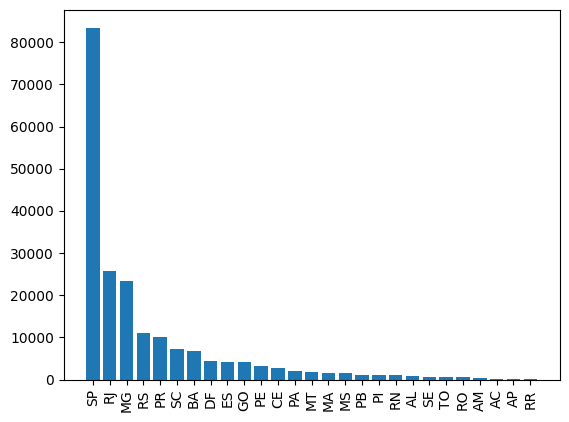

In [28]:
query = """ SELECT customer_state , COUNT(Customer_id)
FROM customers GROUP BY customer_state
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by ="customer_count", ascending=False)

plt.bar( df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.show()

# Calculate the number of orders per month in 2018.

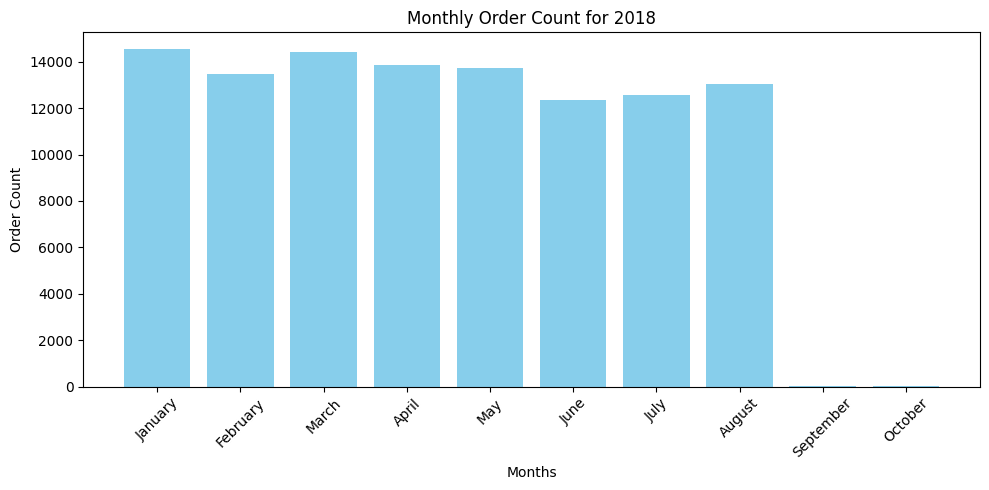

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

query = """
SELECT MONTHNAME(STR_TO_DATE(order_purchase_timestamp, '%m/%d/%Y %H:%i')) AS month_name,
       COUNT(order_id) AS order_count
FROM orders
WHERE YEAR(STR_TO_DATE(order_purchase_timestamp, '%m/%d/%Y %H:%i')) = 2018
GROUP BY month_name
ORDER BY STR_TO_DATE(CONCAT('01 ', month_name, ' 2018'), '%d %M %Y');
"""
cur.execute(query)
data = cur.fetchall()

# Create DataFrame
df = pd.DataFrame(data, columns=["months", "order_count"])

# Ensure correct month order
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]
df["months"] = pd.Categorical(df["months"], categories=month_order, ordered=True)
df = df.sort_values("months")

# Plot
plt.figure(figsize=(10, 5))
plt.bar(df["months"], df["order_count"], color='skyblue')
plt.xticks(rotation=45)
plt.title("Monthly Order Count for 2018")
plt.xlabel("Months")
plt.ylabel("Order Count")
plt.tight_layout()
plt.show()
 


# Find the average number of products per order, grouped by customer city.

In [52]:
query = """WITH count_per_order AS (
    SELECT 
        o.order_id, 
        o.customer_id, 
        COUNT(oi.order_id) AS oc
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY o.order_id, o.customer_id
)

SELECT 
    c.customer_city, 
    ROUND(AVG(cpo.oc), 2) AS average_orders
FROM customers c
JOIN count_per_order cpo ON c.customer_id = cpo.customer_id
GROUP BY c.customer_city;

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer city", "average orders"])
df.head(10)



,Customer city,average orders
0,sao paulo,4.62
1,sao jose dos campos,4.55
2,porto alegre,4.70
3,indaial,4.46
4,treze tilias,5.09
5,rio de janeiro,4.59
6,mario campos,5.33
7,guariba,4.00
8,cuiaba,4.79
9,franca,5.01


# Calculate the percentage of total revenue contributed by each product category.

In [57]:
query = """SELECT 
    UPPER(products.product_category) AS category, 
    round((SUM(payments.payment_value) / 
     (SELECT SUM(payment_value) FROM payments)
    ) * 100,2) AS sales_percentage
FROM products 
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category order by sales_percentage desc;
"""
cur.execute(query)
data = cur.fetchall() 
df = pd.DataFrame(data, columns = ["Customer city", "average products/order"])
df.head(10)

,Customer city,average products/order
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71
5,SPORT LEISURE,34.78
6,HOUSEWARES,27.35
7,AUTOMOTIVE,21.30
8,GARDEN TOOLS,20.95
9,COOL STUFF,19.48


# Identify the correlation between product price and the number of times a product has been purchased.

In [65]:
query = """
    SELECT 
        products.product_category,
        COUNT(order_items.product_id) AS product_count,
        ROUND(AVG(order_items.price), 2)    
    FROM products 
    JOIN order_items ON products.product_id = order_items.product_id
    GROUP BY products.product_category;
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["Category", "product_count", "price"])

arr1 = df["product_count"]
arr2 = df["price"]

print(np.corrcoef([arr1, arr2]))


[[ 1.         -0.10631514]
 [-0.10631514  1.        ]]


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [73]:
query = """
SELECT 
    order_items.seller_id, 
    SUM(payments.payment_value) AS total_payment
FROM order_items 
JOIN payments ON order_items.order_id = payments.order_id
GROUP BY order_items.seller_id;
"""
cur.execute(query)
data = cur.fetchall()
data


[('dd7ddc04e1b6c2c614352b383efe2d36', 64245.44042825699),
 ('cc419e0650a3c5ba77189a1882b7556a', 565238.3202184439),
 ('1f50f920176fa81dab994f9023523100', 1161013.6805104613),
 ('822bad9bc42b51213ba522fe87b7ab5d', 23098.96011352539),
 ('cea729054f157f5870bdd321a958d994', 13832.520050048828),
 ('f8db351d8c4c4c22c6835c19a46f01b0', 306660.75999593735),
 ('d921b68bf747894be13a97ae52b0f386', 70759.07987594604),
 ('955fee9216a65b617aa5c0531780ce60', 945289.2020090595),
 ('c003204e1ab016dfa150abc119207b24', 126646.03968048096),
 ('f8201cab383e484733266d1906e2fdfa', 4579.319976806641),
 ('392353362d22cc2c236e1ee81ff19890', 4939.400077819824),
 ('620c87c171fb2a6dd6e8bb4dec959fc6', 581071.7994704247),
 ('abcd2cb37d46c2c8fb1bf071c859fc5b', 30950.280212402344),
 ('9dda5bbacd45e18d6485fee649205d09', 16481.48014831543),
 ('25be943a321c8938947bdaabca979a90', 3630.2000732421875),
 ('c6bda72e4dbf5c5866b13cb1810c6d03', 62451.4404296875),
 ('897060da8b9a21f655304d50fd935913', 236593.59958219528),
 ('37be5